# Part 1.2: Policies and Exploration

Welcome to the second notebook in our RL foundations series! In the previous notebook, we learned what RL is and how agents interact with environments. Now we'll explore how agents actually make decisions.

## Recap from Notebook 1.1
- RL agents learn through trial and error by interacting with an environment
- The agent-environment loop: observe → act → receive reward → repeat
- The Markov property: the future depends only on the present state
- FrozenLake is our running example - a grid world with slippery ice

## What This Notebook Covers
- **Policies**: How agents decide which actions to take
- **Policy Evaluation**: Empirically testing how well a policy performs
- **Exploration vs Exploitation**: The fundamental RL dilemma
- **Prediction vs Control**: Two core problems in RL

## What This Notebook Does NOT Cover

| Topic | Why Not Here | How It Differs From What We Cover |
|-------|--------------|-----------------------------------|
| **Value function algorithms** | This notebook focuses on what policies ARE and how they work. Algorithms to learn/improve policies come in later notebooks (starting with Part 3). | We explain what a policy is (a mapping from states to actions) and how to evaluate it. Value function algorithms like Q-learning and SARSA use value functions to find better policies — they're the "how to improve" coming later. |
| **Deep reinforcement learning** | Deep RL uses neural networks to represent policies, adding significant complexity. We start with simple tabular policies where states and actions are discrete. | In this notebook, policies are simple functions or lookup tables (e.g., "state 6 → action RIGHT"). Deep RL uses neural networks to handle high-dimensional state spaces like images — a topic that builds on these foundations. |
| **Multi-agent coordination** | Multi-agent RL involves multiple agents with potentially conflicting goals. We focus on single-agent decision making first. | Here, one agent follows a policy in isolation. Multi-agent settings require reasoning about other agents' policies, game theory, and coordination — fundamentally different from the single-agent exploration-exploitation trade-off we cover. |


## How to Read This Notebook
1. **Concepts first**: Each section introduces key ideas (deterministic vs stochastic policies, exploration vs exploitation)
2. **Code examples**: Run the cells to see policies in action on FrozenLake
3. **Visualizations**: Plots show how different policies behave and why exploration matters
4. **Checkpoints**: Use these to verify your understanding before moving on

Let's begin!

---

## Setup

In [12]:
# Install necessary libraries (uncomment if needed)
# !pip install gymnasium[toy-text] numpy matplotlib seaborn

In [13]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
import time

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("Setup complete!")

Setup complete!


In [14]:
# Helper function from notebook 1.1
def visualize_frozenlake(env, current_state=None, title="FrozenLake Environment"):
    """Visualize the FrozenLake grid with the current state highlighted."""
    desc = env.unwrapped.desc.astype(str)
    nrow, ncol = desc.shape
    
    fig, ax = plt.subplots(figsize=(6, 6))
    colors = {'S': 'lightblue', 'F': 'white', 'H': 'lightcoral', 'G': 'lightgreen'}
    
    for i in range(nrow):
        for j in range(ncol):
            cell = desc[i, j]
            color = colors.get(cell, 'white')
            state_idx = i * ncol + j
            if current_state is not None and state_idx == current_state:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True, 
                                     facecolor='yellow', edgecolor='black', linewidth=2)
            else:
                rect = plt.Rectangle((j, nrow-1-i), 1, 1, fill=True,
                                     facecolor=color, edgecolor='black', linewidth=1)
            ax.add_patch(rect)
            ax.text(j + 0.5, nrow - 1 - i + 0.5, cell,
                   ha='center', va='center', fontsize=20, fontweight='bold')
    
    ax.set_xlim(0, ncol)
    ax.set_ylim(0, nrow)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    legend_elements = [
        plt.Rectangle((0, 0), 1, 1, facecolor='lightblue', label='S: Start'),
        plt.Rectangle((0, 0), 1, 1, facecolor='white', edgecolor='black', label='F: Frozen (safe)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightcoral', label='H: Hole (game over)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='lightgreen', label='G: Goal (reward!)'),
        plt.Rectangle((0, 0), 1, 1, facecolor='yellow', edgecolor='black', linewidth=2, label='Current position')
    ]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    return fig, ax

---

# 1. What Is a Policy?

A **policy** ($\pi$) is the agent's behavior function - it determines how the agent chooses actions based on states.

The policy is the heart of an RL agent. Everything else (value functions, models) ultimately serves to find or improve the policy.

## Two Types of Policies

### Deterministic Policy

$$a = \pi(s)$$

**Plain English:** "The action equals the policy applied to the state."

<details>

<summary>Formula components</summary>

- $a$ = the action selected by the policy
- $\pi$ = the policy (a function that determines behavior)
- $s$ = the current state

</details>

For a given state, **always returns the same action**.

- Simple to implement and understand
- May be optimal in fully observable environments
- Example: "In state 5, always go LEFT"

In [15]:
# Example: Deterministic Policies
def always_right_policy(state):
    """A simple deterministic policy: always go RIGHT (action 2)."""
    return 2  # Always RIGHT

def always_down_policy(state):
    """A simple deterministic policy: always go DOWN (action 1)."""
    return 1  # Always DOWN

print("Deterministic Policy Examples")
print("=" * 40)
action_names = {0: 'LEFT', 1: 'DOWN', 2: 'RIGHT', 3: 'UP'}

for state in range(4):
    right_action = always_right_policy(state)
    down_action = always_down_policy(state)
    print(f"State {state}: always_right → {right_action} ({action_names[right_action]}), "
          f"always_down → {down_action} ({action_names[down_action]})")

Deterministic Policy Examples
State 0: always_right → 2 (RIGHT), always_down → 1 (DOWN)
State 1: always_right → 2 (RIGHT), always_down → 1 (DOWN)
State 2: always_right → 2 (RIGHT), always_down → 1 (DOWN)
State 3: always_right → 2 (RIGHT), always_down → 1 (DOWN)


Both policies are deterministic because for example in state 1:
- the always go right policy will always choose the action RIGHT
- the always go down policy will always choose the action DOWN

### Stochastic Policy

$$\pi(a|s) = P[A_t = a | S_t = s]$$

**Plain English:** "The probability of selecting action a in state s equals the probability that action A at time t is a, given that the state S at time t is s."

<details>

<summary>Formula components</summary>

- $\pi(a|s)$ = the probability of taking action $a$ in state $s$ (read as "pi of a given s")
- $P[\cdot]$ = probability of the event in brackets
- $A_t$ = the action random variable at time step $t$
- $a$ = a specific action value
- $S_t$ = the state random variable at time step $t$
- $s$ = a specific state value
- $|$ = "given that" (conditional probability notation)

</details>

For a given state, returns a **probability distribution** over actions.

- More flexible
- Useful for exploration
- Can be optimal in partially observable environments
- Example: "In state 5, go LEFT with 70% probability, RIGHT with 30%"

In [16]:
# Example: Stochastic Policies
def uniform_random_policy(state, n_actions=4):
    """Uniform random policy: equal probability for all actions."""
    return np.ones(n_actions) / n_actions

def biased_policy(state, n_actions=4):
    """A biased policy: prefers going DOWN and RIGHT."""
    # [LEFT, DOWN, RIGHT, UP]
    return np.array([0.1, 0.4, 0.4, 0.1])

print("Stochastic Policy Examples")
print("=" * 40)
print("\nUniform Random Policy (same for all states):")
probs = uniform_random_policy(0)
for action, prob in enumerate(probs):
    print(f"  P(A={action}|S=0) = {prob:.2f} ({action_names[action]})")

print("\nBiased Policy (prefers DOWN and RIGHT):")
probs = biased_policy(0)
for action, prob in enumerate(probs):
    print(f"  P(A={action}|S=0) = {prob:.2f} ({action_names[action]})")

Stochastic Policy Examples

Uniform Random Policy (same for all states):
  P(A=0|S=0) = 0.25 (LEFT)
  P(A=1|S=0) = 0.25 (DOWN)
  P(A=2|S=0) = 0.25 (RIGHT)
  P(A=3|S=0) = 0.25 (UP)

Biased Policy (prefers DOWN and RIGHT):
  P(A=0|S=0) = 0.10 (LEFT)
  P(A=1|S=0) = 0.40 (DOWN)
  P(A=2|S=0) = 0.40 (RIGHT)
  P(A=3|S=0) = 0.10 (UP)


Sampling Actions from Policies

**Question this plot answers:** 'Do sampled actions match the policy probabilities?'



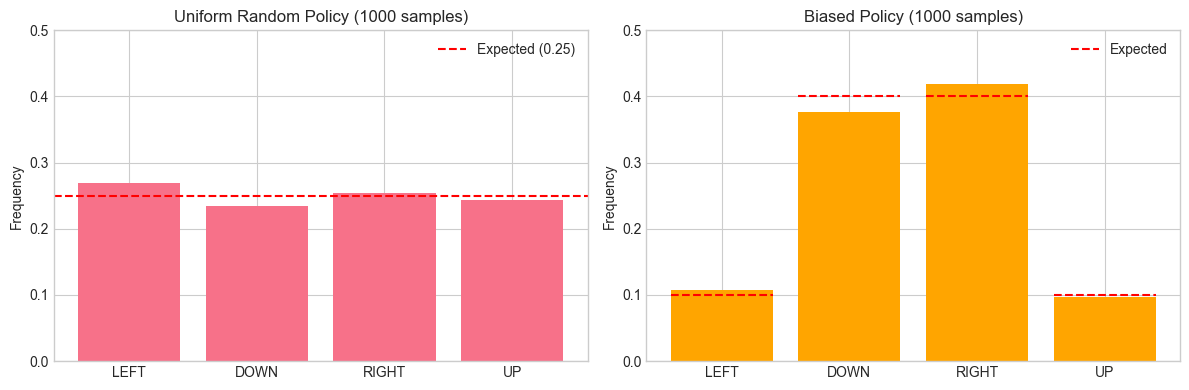

In [17]:
# Sampling actions from stochastic policies
def sample_action(policy_probs):
    """Sample an action according to the policy probabilities."""
    return np.random.choice(len(policy_probs), p=policy_probs)

print("Sampling Actions from Policies")
print("=" * 40)
print("\n**Question this plot answers:** 'Do sampled actions match the policy probabilities?'\n")

n_samples = 1000

# Sample from uniform random policy
uniform_samples = [sample_action(uniform_random_policy(0)) for _ in range(n_samples)]
uniform_counts = np.bincount(uniform_samples, minlength=4)

# Sample from biased policy
biased_samples = [sample_action(biased_policy(0)) for _ in range(n_samples)]
biased_counts = np.bincount(biased_samples, minlength=4)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(list(action_names.values()), uniform_counts / n_samples)
axes[0].set_title(f'Uniform Random Policy ({n_samples} samples)')
axes[0].set_ylabel('Frequency')
axes[0].set_ylim(0, 0.5)
axes[0].axhline(y=0.25, color='r', linestyle='--', label='Expected (0.25)')
axes[0].legend()

axes[1].bar(list(action_names.values()), biased_counts / n_samples, color='orange')
axes[1].set_title(f'Biased Policy ({n_samples} samples)')
axes[1].set_ylabel('Frequency')
axes[1].set_ylim(0, 0.5)
expected = [0.1, 0.4, 0.4, 0.1]
for i, exp in enumerate(expected):
    axes[1].plot([i-0.4, i+0.4], [exp, exp], 'r--')
axes[1].plot([], [], 'r--', label='Expected')
axes[1].legend()

plt.tight_layout()
plt.show()

#### Understanding the Plot: Do Sampled Actions Match Policy Probabilities?

**Answer: Yes! The sampled action frequencies closely match the policy probabilities.**

##### What This Plot Shows

The plot above compares two different stochastic policies by sampling actions 1,000 times from each and counting how often each action was selected.

**Left Plot - Uniform Random Policy:**
- **Expected behavior:** Each action should be chosen 25% of the time (0.25 probability)
- **What we observe:** All four bars are approximately at 0.25 (the red dashed line)
- **Interpretation:** When we sample many actions, the frequencies converge to the policy's true probabilities

**Right Plot - Biased Policy:**
- **Expected behavior:** LEFT and UP should be chosen 10% of the time (0.1), while DOWN and RIGHT should be chosen 40% of the time (0.4)
- **What we observe:** The bars match the expected values shown by the red dashed lines
- **Interpretation:** Even with an uneven probability distribution, the sampling correctly reflects the policy

##### Why This Matters

This demonstrates a fundamental concept in RL:

1. **Stochastic policies define probabilities, not certainties**: The policy says "choose DOWN with 40% probability," not "always choose DOWN"
2. **Sampling implements the policy**: In practice, we can't execute a probability—we must sample a concrete action. This plot proves our sampling method works correctly.
3. **Law of large numbers**: With enough samples (1,000 in this case), the empirical frequencies approach the theoretical probabilities
4. **Foundation for learning**: Later, we'll learn algorithms that adjust these probabilities based on experience. This plot shows that our sampling mechanism will faithfully execute whatever policy we learn.

##### Quick Check

If you ran this experiment with only 10 samples instead of 1,000, you might see frequencies like [0.3, 0.4, 0.2, 0.1] for the uniform policy instead of [0.25, 0.25, 0.25, 0.25]. This is normal—randomness causes variation in small samples. But with 1,000 samples, we get very close to the true probabilities!

> **Checkpoint — You should now understand:**
> - The difference between deterministic and stochastic policies
> - How to sample actions from a stochastic policy
> - Why a policy is the core component of an RL agent

---

# 2. Evaluating a Fixed Policy (Empirical)

How do we know if a policy is good? The simplest approach is **empirical evaluation**: run the policy many times and measure performance.


## Metrics for Policy Evaluation

| Metric | Description | FrozenLake Interpretation |
|--------|-------------|---------------------------|
| **Success rate** | % of episodes reaching the goal | Higher is better |
| **Average return** | Mean cumulative reward | Same as success rate for FrozenLake (+1 only at goal) |
| **Average episode length** | Mean steps per episode | Lower might be better (faster) |
| **Variance** | Consistency of performance | Lower means more reliable |

## What Is an Episode?

An **episode** is a complete run of the agent-environment interaction from start to finish. Think of it like a single game or trial.

### Episode Structure

```
Start → Observe → Act → Get Reward → Observe → Act → ... → End
```

### When Does an Episode End?

In **general RL theory**, an episode ends when the agent reaches a **terminal state**—a state with no successor. That's it. The distinction below is specific to how Gymnasium implements this concept.

**Gymnasium-Specific Implementation:**

Gymnasium's `env.step()` returns two separate boolean flags to distinguish *why* an episode ended:

1. **Terminated**: The environment reaches a natural ending (a true terminal state)
   - In FrozenLake: falling into a Hole (H) or reaching the Goal (G)
   - This corresponds to the classical RL notion of terminal states
   
2. **Truncated**: An artificial limit is reached (not a true terminal state)
   - A maximum step limit is imposed to prevent infinite episodes
   - Example: "You have 100 steps max to reach the Goal"
   - The agent *could* continue, but the episode is cut short for practical reasons

**Why does Gymnasium distinguish these?** Because they should be handled differently during learning. When an episode is *terminated*, the value of the terminal state is truly zero (no future rewards possible). When an episode is *truncated*, the state may still have value—the agent just ran out of time. Some algorithms need this distinction to avoid incorrect value estimates.

### FrozenLake Episode Examples

**Successful Episode (terminated):**
```
Start (S) → Move → Frozen (F) → Move → Frozen (F) → Move → Goal (G) ✓
Total reward: +1
Episode length: 3 steps
```

**Failed Episode (terminated):**
```
Start (S) → Move → Frozen (F) → Move → Hole (H) ✗
Total reward: 0
Episode length: 2 steps
```

**Truncated Episode (hit step limit):**
```
Start (S) → Move → ... → 100 steps later → Still not at Goal ⏱
Total reward: 0
Episode length: 100 steps (hit limit)
```

### Why Episodes Matter for Evaluation

When we evaluate a policy, we run it for **many episodes** (e.g., 1,000 episodes) to get reliable statistics:

- **One episode** might succeed or fail due to luck (remember the slippery ice!)
- **Many episodes** reveal the true quality of the policy through averaging

Think of it like flipping a coin: one flip doesn't tell you much, but 1,000 flips reveal if it's fair.

## Evaluation example

In [18]:
# Helper function to run episodes
def run_episode(env, policy_fn, max_steps=100):
    """Run a single episode with the given policy.
    
    Args:
        env: The Gymnasium environment
        policy_fn: Function that takes state and returns action (or probabilities)
        max_steps: Maximum steps per episode
    
    Returns:
        total_reward: Sum of rewards received
        steps: Number of steps taken
    """
    observation, info = env.reset()
    total_reward = 0
    steps = 0
    
    for _ in range(max_steps):
        # Get action from policy
        policy_output = policy_fn(observation)
        
        # If policy returns probabilities, sample; otherwise use directly
        if isinstance(policy_output, np.ndarray):
            action = sample_action(policy_output)
        else:
            action = policy_output
        
        observation, reward, terminated, truncated, info = env.step(action)
        total_reward += reward
        steps += 1
        
        if terminated or truncated:
            break
    
    return total_reward, steps

> Note: In this tutorial, we allow policies to return either a concrete action or a probability distribution over actions. This keeps the code simple while supporting both deterministic and stochastic policies.

In [19]:
# Compare different policies
print("**Question this comparison answers:** 'Which simple policy works best for FrozenLake?'\n")

env = gym.make("FrozenLake-v1", is_slippery=True)
n_episodes = 1000

policies = {
    'Uniform Random': uniform_random_policy,
    'Biased (DOWN/RIGHT)': biased_policy,
    'Always RIGHT': lambda s: 2,
    'Always DOWN': lambda s: 1
}

results = {}
for name, policy in policies.items():
    rewards = []
    for _ in range(n_episodes):
        reward, _ = run_episode(env, policy)
        rewards.append(reward)
    results[name] = rewards
    print(f"{name}: Success rate = {np.mean(rewards)*100:.1f}%")

env.close()

**Question this comparison answers:** 'Which simple policy works best for FrozenLake?'

Uniform Random: Success rate = 1.2%
Biased (DOWN/RIGHT): Success rate = 2.7%
Always RIGHT: Success rate = 3.5%
Always DOWN: Success rate = 4.5%


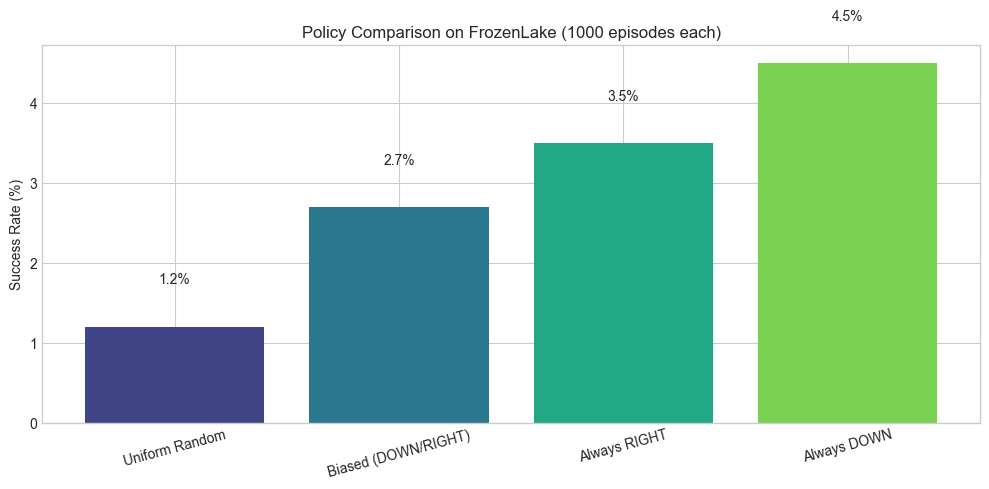

In [20]:
# Visualize policy comparison
fig, ax = plt.subplots(figsize=(10, 5))

success_rates = [np.mean(results[name]) * 100 for name in policies.keys()]
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(policies)))

bars = ax.bar(policies.keys(), success_rates, color=colors)
ax.set_ylabel('Success Rate (%)')
ax.set_title(f'Policy Comparison on FrozenLake ({n_episodes} episodes each)')

for bar, rate in zip(bars, success_rates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{rate:.1f}%', ha='center', va='bottom', fontsize=10)

plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

### Understanding the Results: How Can "Always DOWN" Reach the Goal?

Looking at the results above, you might wonder: if the "Always DOWN" policy only chooses to go down, how can it ever reach the Goal at state 15 (bottom-right corner)? The agent starts at state 0 (top-left) and the Goal is diagonally across!

The answer lies in the **slippery ice**. Recall from Notebook 1.1 that when the agent chooses an action, it only moves in that direction **1/3 of the time**. The other 2/3 of the time, it slips perpendicular to the intended direction:

| Intended Action | Actual Movement Probabilities |
|----------------|-------------------------------|
| DOWN | 1/3 DOWN, 1/3 LEFT, 1/3 RIGHT |
| RIGHT | 1/3 RIGHT, 1/3 UP, 1/3 DOWN |
| UP | 1/3 UP, 1/3 LEFT, 1/3 RIGHT |
| LEFT | 1/3 LEFT, 1/3 UP, 1/3 DOWN |


### A Successful (Lucky!) Episode with "Always DOWN"

```
State 0:  Choose DOWN → Actually go DOWN → State 4
State 4:  Choose DOWN → Actually go DOWN → State 8
State 8:  Choose DOWN → Slip RIGHT → State 9
State 9:  Choose DOWN → Slip RIGHT → State 10
State 10: Choose DOWN → Actually go DOWN → State 14
State 14: Choose DOWN → Slip RIGHT → State 15 (GOAL!) ✓
```

### The Paradox: Deterministic Policy, Random Outcomes

This illustrates an important RL concept: **even a deterministic policy produces different outcomes in a stochastic environment**.

- The policy is deterministic: always outputs "DOWN"
- But the outcomes are random: the agent ends up in different states each episode
- Success depends on the random transitions, not the policy's "skill"

### Why This Matters

A **good** policy would account for stochasticity. For example, if you're near a Hole on your left, you might choose to go RIGHT so that even if you slip LEFT or DOWN, you're less likely to fall in. This is why learning optimal policies in stochastic environments is challenging and interesting!


> **Checkpoint — You should now understand:**
> - The different types of policies
> - How to empirically evaluate a policy by running many episodes
> - Why simple policies achieve surprisingly low success rates
> - How stochastic transitions cause the same policy to produce different outcomes

---

# 3. Exploration vs Exploitation

One of the key challenges in RL is the **exploration-exploitation dilemma**:

- **Exploration**: Try new actions to discover their rewards
- **Exploitation**: Use known good actions to maximize reward

If we only exploit, we might miss better options. If we only explore, we waste time on suboptimal actions.

## Example: Restaurant Choice

- **Exploitation**: Go to your favorite restaurant (guaranteed good meal)
- **Exploration**: Try a new restaurant (might be better... or worse)

## Exploration vs Exploitation in FrozenLake

### The Challenge of Pure Exploitation

Imagine an agent that has only experienced a few episodes and found that going DOWN from state 0 led to falling into a Hole a few steps later. If it purely exploits this knowledge:

```
"DOWN from state 0 → fell into Hole → avoid DOWN forever"
```

But this is wrong! The agent fell into the Hole because of **slippery ice**, not because DOWN is inherently bad. In fact, DOWN might be part of the optimal path. Without exploration, the agent would never discover this.

### The Challenge of Pure Exploration

On the other hand, if the agent always explores randomly:
- It has only ~1-4% chance of reaching the Goal (as we saw earlier)
- Even if it finds a good path, it won't consistently use it
- It keeps trying actions it already knows are bad

### Why Exploration is Critical in FrozenLake

| Reason | Explanation |
|--------|-------------|
| **Sparse rewards** | The agent might need hundreds of random episodes before accidentally reaching the Goal even once. Without exploration, it might never discover that +1 reward exists! |
| **Stochastic outcomes** | The same action can lead to different states. The agent needs multiple samples to learn the true transition probabilities. |
| **Misleading early experiences** | An early "lucky" or "unlucky" slip might give the wrong impression about an action's value. |
| **Multiple paths to Goal** | There might be several viable paths. Exploitation after finding one path means never discovering potentially better alternatives. |

## Common Strategy: ε-Greedy

The **ε-greedy** (epsilon-greedy) strategy balances exploration and exploitation:

- With probability $1-\epsilon$: choose the **best known action** (exploit)
- With probability $\epsilon$: choose a **random action** (explore)

**In plain terms:**

```
if random() < ε:
    action = random action          # Explore
else:
    action = best known action      # Exploit
```

Where "best known action" means the action that has performed best so far based on the agent's experience. (We'll formalize this as Q(s,a) in the next notebook on value functions.)

Early in training, the *best* action may simply be the least poorly estimated one, which is why exploration remains necessary even when exploiting.

### Common ε Values

| ε Value | Behavior |
|---------|----------|
| ε = 0 | Pure exploitation (always take best known action) |
| ε = 0.1 | Mostly exploit with occasional exploration (common in practice) |
| ε = 0.5 | Equal mix of exploration and exploitation |
| ε = 1 | Pure exploration (always random) |

### Demonstrate ε-Greedy

In [21]:
# Implement epsilon-greedy exploration
def epsilon_greedy_policy(Q, state, epsilon):
    """
    Epsilon-greedy policy.
    
    Args:
        Q: Action-value function (dict mapping state to array of action values)
        state: Current state
        epsilon: Exploration probability (0 to 1)
    
    Returns:
        action: Selected action
    """
    if np.random.random() < epsilon:
        # Explore: random action
        return np.random.randint(len(Q[state]))
    else:
        # Exploit: best action
        return np.argmax(Q[state])

Epsilon-Greedy Policy Demonstration

**Question this plot answers:** 'How does ε affect the balance between exploration and exploitation?'

Q-values for state 0: [1.0, 5.0, 2.0, 3.0]
Best action: 1 (DOWN) with Q-value 5.0


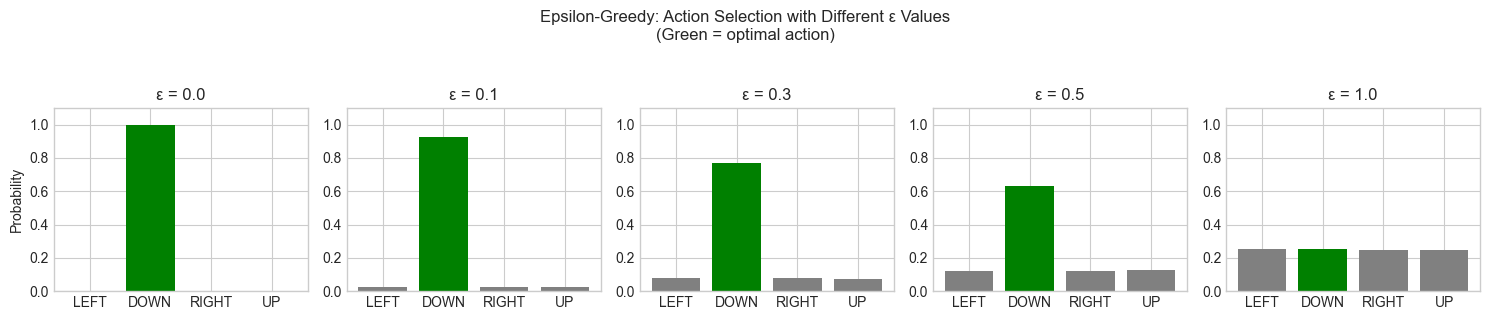


ε = 0.0: Always exploit (100% best action)
ε = 1.0: Always explore (25% each action)
ε = 0.1: Mostly exploit with some exploration (typical in practice)


In [22]:
# Demonstrate epsilon-greedy
print("Epsilon-Greedy Policy Demonstration")
print("=" * 50)
print("\n**Question this plot answers:** 'How does ε affect the balance between exploration and exploitation?'\n")

# Suppose we have learned these Q-values for state 0
# Q[state][action] = expected return
Q = {0: [1.0, 5.0, 2.0, 3.0]}  # Action 1 (DOWN) is best with value 5.0

print(f"Q-values for state 0: {Q[0]}")
print(f"Best action: 1 (DOWN) with Q-value 5.0")

# Count actions taken with different epsilon values
n_samples = 10000
epsilons = [0.0, 0.1, 0.3, 0.5, 1.0]

fig, axes = plt.subplots(1, len(epsilons), figsize=(15, 3))

for idx, epsilon in enumerate(epsilons):
    actions = [epsilon_greedy_policy(Q, 0, epsilon) for _ in range(n_samples)]
    counts = np.bincount(actions, minlength=4)
    
    colors = ['gray' if i != 1 else 'green' for i in range(4)]
    axes[idx].bar(['LEFT', 'DOWN', 'RIGHT', 'UP'], counts / n_samples, color=colors)
    axes[idx].set_title(f'ε = {epsilon}')
    axes[idx].set_ylim(0, 1.1)
    if idx == 0:
        axes[idx].set_ylabel('Probability')

plt.suptitle('Epsilon-Greedy: Action Selection with Different ε Values\n(Green = optimal action)', 
             fontsize=12, y=1.05)
plt.tight_layout()
plt.show()

print("\nε = 0.0: Always exploit (100% best action)")
print("ε = 1.0: Always explore (25% each action)")
print("ε = 0.1: Mostly exploit with some exploration (typical in practice)")

#### Understanding the Plot: How Does ε Control Exploration vs Exploitation?

**Answer: Higher ε means more exploration (random actions), lower ε means more exploitation (best known action).**

##### How to Read This Plot

Each subplot shows **action selection probabilities** for a different ε value:

- **X-axis**: The four possible actions (LEFT, DOWN, RIGHT, UP)
- **Y-axis**: Probability of selecting each action (0 to 1.0)
- **Green bar**: The optimal action (DOWN, which has Q-value 5.0)
- **Gray bars**: Non-optimal actions

##### Walking Through Each ε Value

| ε | Exploit Probability (1-ε) | Explore Probability (ε) | What We See |
|---|---------------------------|-------------------------|-------------|
| **0.0** | 100% | 0% | Only green bar at 1.0 — always takes the best action |
| **0.1** | 90% | 10% | Green bar dominates (~92.5%), tiny gray bars (~2.5% each) |
| **0.3** | 70% | 30% | Green bar still leads (~77.5%), more visible gray bars (~7.5% each) |
| **0.5** | 50% | 50% | Green bar at ~62.5%, gray bars at ~12.5% each |
| **1.0** | 0% | 100% | All bars equal at 25% — purely random selection |

##### The Math Behind ε = 0.1

When ε = 0.1, the agent:
- **90% of the time (1-ε)**: Chooses the best action (DOWN) → P(DOWN) from exploitation = 0.9
- **10% of the time (ε)**: Chooses randomly among 4 actions → Each action gets 0.1/4 = 0.025

Therefore:
- P(DOWN) = 0.9 + 0.025 = **0.925** (exploitation + its share of exploration)
- P(LEFT) = P(RIGHT) = P(UP) = 0.025 = **0.025** (only from random exploration)

This is why the green bar isn't exactly at 0.9 — the optimal action also gets picked during random exploration!

##### Key Knowledge: The Exploration-Exploitation Trade-off

1. **ε = 0 is dangerous during learning**: If the agent has wrong initial estimates, it will never discover better actions. Pure exploitation locks in whatever the agent first believed was best.

2. **ε = 1 is inefficient**: Random behavior ignores everything the agent has learned. Even if it knows the best action, it only takes it 25% of the time.

3. **ε = 0.1 is a common practical choice**: The agent exploits its knowledge 90% of the time while still occasionally trying alternatives. This catches errors in value estimates without sacrificing too much performance.

4. **ε should typically decay over time**: Early in learning, explore more (high ε) because estimates are unreliable. Later, exploit more (low ε) because estimates have improved.

##### Why This Matters for RL

The ε-greedy plot visualizes the **core mechanism** that enables learning:
- Without exploration (ε = 0), the agent can't discover if its Q-values are wrong
- Without exploitation (ε = 1), the agent can't benefit from what it has learned
- The right balance (ε ≈ 0.1, often decaying) allows the agent to both **learn** and **perform**

> **Optional — Advanced Topic: Other Exploration Strategies**
>
> Beyond ε-greedy, there are more sophisticated exploration strategies:
>
> - **Optimistic Initialization**: Start with high value estimates, encouraging visits to unexplored states
> - **UCB (Upper Confidence Bound)**: Choose actions based on both estimated value AND uncertainty
> - **Thompson Sampling**: Maintain probability distributions over values and sample from them
> - **Entropy Regularization**: Add bonus reward for acting randomly (encourages diverse behavior)
>
> These methods are especially useful when exploration is expensive (e.g., robotics, real-world systems).


> **Checkpoint — You should now understand:**
> - The exploration-exploitation dilemma and why both are necessary
> - How ε-greedy balances exploration and exploitation
> - Why different ε values lead to different behaviors

---

# 4. Prediction vs Control

Two fundamental problems in RL:

## 4.1 Prediction (Policy Evaluation)

- **Goal**: Given a policy $\pi$, estimate how good it is
- **Question**: "How good is this policy?"
- **Output**: Value function $V^\pi$ or $Q^\pi$

**Notation explained:**
- $V^\pi$ = the state-value function for policy $\pi$ (how good is each state when following policy $\pi$)
- $Q^\pi$ = the action-value function for policy $\pi$ (how good is each action in each state when following policy $\pi$)
- The superscript $\pi$ indicates "when following policy $\pi$"

## 4.2 Control (Policy Optimization)

- **Goal**: Find the optimal policy $\pi^*$ that maximizes value
- **Question**: "What is the best policy?"
- **Output**: Optimal policy $\pi^*$

**Notation explained:**
- $\pi^*$ = the optimal policy (the best possible policy, marked with asterisk * to indicate "optimal")

Control often builds on prediction: if we can evaluate policies, we can compare them and find the best one.

## Prediction vs Control in FrozenLake

### Prediction: "How Good is the Random Policy?"

Suppose we have a **uniform random policy** (25% chance for each action). The prediction problem asks:

> "If I follow this random policy, what's my expected return from each state?"

| State | Expected Value | Interpretation |
|-------|---------------|----------------|
| 0 (Start) | ~0.014 | From the start, random walking reaches Goal ~1.4% of the time |
| 10 (Near Goal) | ~0.05 | Even close to Goal, random actions rarely succeed |
| 14 (Adjacent to Goal) | ~0.15 | Best position, but still low due to random actions |
| 5, 7, 11, 12 (Holes) | 0 | Terminal states - no future rewards possible |

### Control: "What's the Best Way to Navigate?"

The control problem asks:

> "What action should I take in each state to maximize my chance of reaching the Goal?"

| State | Optimal Action | Why |
|-------|---------------|-----|
| 0 (Start) | DOWN or LEFT | Moves toward safe left-side path, away from Hole at state 5 |
| 4 | DOWN | Continues down the safe left corridor |
| 8 | RIGHT | Start moving toward Goal |
| 9 | DOWN | Head toward state 13 |
| 10 | DOWN | Move toward state 14, adjacent to Goal |
| 14 | RIGHT | One step to Goal! |

The optimal policy achieves a much higher success rate compared to the random policy's ~1.4%.

### The Relationship: Prediction Enables Control

Control algorithms typically use prediction as a building block:

```
┌─────────────────────────────────────────────────────────┐
│                    CONTROL LOOP                         │
│                                                         │
│   1. Start with some policy π                           │
│                     ↓                                   │
│   2. PREDICTION: Evaluate π → compute V^π or Q^π        │
│                     ↓                                   │
│   3. IMPROVEMENT: Update π based on values              │
│         (e.g., be greedy w.r.t. Q^π)                    │
│                     ↓                                   │
│   4. Repeat until policy stops improving                │
│                     ↓                                   │
│   5. Output: Optimal policy π*                          │
└─────────────────────────────────────────────────────────┘
```

### Why Both Problems Matter

| Problem | FrozenLake Application | Real-World Analogy |
|---------|----------------------|-------------------|
| **Prediction** | "If I always go DOWN, what's my success rate?" | "If I invest in this stock, what's my expected return?" |
| **Control** | "What's the best action in each state?" | "How should I allocate my portfolio to maximize returns?" |


> **Checkpoint — You should now understand:**
> - The difference between prediction (evaluating a policy) and control (finding the best policy)
> - Why prediction is often a building block for control
> - How these concepts apply to FrozenLake

---

# 5. Summary and Concept Map

In this notebook, we covered the key concepts around policies.

## Key Concepts


```
POLICIES AND EXPLORATION
========================

POLICY (π)
──────────
How the agent decides which action to take

├── Deterministic: a = π(s)
│   └── Always returns the same action for a given state
│
└── Stochastic: π(a|s) = P[A=a | S=s]
    └── Returns probability distribution over actions


EXPLORATION vs EXPLOITATION
───────────────────────────
The fundamental RL dilemma

├── Exploration: Try new actions to discover rewards
│   └── Risk: Might waste time on bad actions
│
├── Exploitation: Use known good actions
│   └── Risk: Might miss better options
│
└── ε-Greedy: Balance both
    └── With prob ε: explore (random)
    └── With prob 1-ε: exploit (best known)


PREDICTION vs CONTROL
─────────────────────
Two core RL problems

├── Prediction: "How good is this policy?"
│   └── Estimate value function V^π or Q^π
│
└── Control: "What is the best policy?"
    └── Find optimal policy π*
    └── Uses prediction as building block
```

## What's Next?

In the next notebook (**01_3_value_functions_and_models.ipynb**), we'll learn about:
- **Value Functions**: How to quantify "how good" a state or action is
- **The Discount Factor**: Why we discount future rewards
- **Models**: How to represent environment dynamics

---

# 6. Your Turn

## Exercise 1: Create a "Safe" Policy

Now it's your turn to experiment! Try writing a deterministic policy that attempts to avoid holes by being more strategic about its movements.

**Task:** Create a `safe_policy(state)` function that:
1. For states in the top row (0, 1, 2, 3): always go DOWN to avoid slipping into holes to the right
2. For states in the left column (0, 4, 8): always go DOWN to stay in the "safe corridor"
3. For other states: go RIGHT to move toward the goal

**Why this matters:** This exercise teaches you to think about how policy design interacts with environment stochasticity. In later notebooks, you'll learn algorithms that automatically discover policies like this (and better)!

**Hint:** Even a "smart" policy struggles because of the slippery ice - but can you beat 4%?

In [23]:
# YOUR CODE HERE
# Uncomment and complete the function below, then run the cell to test it!

# def safe_policy(state):
#     """
#     A policy that tries to avoid holes by navigating strategically.
#     
#     Grid layout (4x4):
#     S  F  F  F      States: 0  1  2  3
#     F  H  F  H              4  5  6  7
#     F  F  F  H              8  9  10 11
#     H  F  F  G              12 13 14 15
#     
#     Actions: 0=LEFT, 1=DOWN, 2=RIGHT, 3=UP
#     """
#     # Top row (states 0, 1, 2, 3) - go DOWN
#     if state in [0, 1, 2, 3]:
#         return 1  # DOWN
#     
#     # Left column (states 4, 8) - go DOWN  
#     elif state in [4, 8]:
#         return 1  # DOWN
#     
#     # TODO: Add your logic for other states
#     # Hint: Think about how to navigate from the bottom-left toward the goal
#     else:
#         return 2  # RIGHT (default)

# # Test your policy
# env = gym.make("FrozenLake-v1", is_slippery=True)
# n_episodes = 1000
# rewards = []
# for _ in range(n_episodes):
#     reward, _ = run_episode(env, safe_policy)
#     rewards.append(reward)
# print(f"Your Safe Policy: Success rate = {np.mean(rewards)*100:.1f}%")
# env.close()

## Exercise 2: Conceptual Question

Consider two exploration strategies:

**Strategy A:** ε = 0.5 throughout training (always 50% random)

**Strategy B:** ε starts at 1.0 and decays to 0.01 over time

**Question:** Which strategy would you expect to perform better for FrozenLake, and why? Think about the trade-offs at the beginning vs end of training.

<details>
<summary>Click to see answer</summary>

**Strategy B (decaying ε) is generally better.**

**Early in training:**
- High ε (near 1.0) is good because the agent knows nothing
- Random exploration helps discover the Goal and learn which paths work

**Late in training:**
- Low ε (near 0.01) is good because the agent now knows good actions
- Mostly exploiting the learned policy maximizes reward
- Occasional exploration catches any remaining opportunities

**Strategy A's problem:**
- Even after learning the optimal path, it still takes random actions 50% of the time
- This wastes opportunities and makes performance inconsistent

This is why ε-decay (or "annealing") is common in practice!

</details>

---

**Congratulations! You've completed Part 1.2 of the RL Tutorial!**

Key takeaways:
- Policies map states to actions (deterministic or stochastic)
- Simple policies achieve surprisingly low success rates in FrozenLake
- ε-greedy balances exploration and exploitation
- Prediction evaluates policies; control finds optimal policies

Next: 01_3_value_functions_and_models.ipynb